## MNIST Classification with CNN

c:\Users\adarsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 178ms/step - accuracy: 0.8165 - loss: 0.7071 - val_accuracy: 0.1113 - val_loss: 6.3764 - learning_rate: 0.0010
Epoch 2/100


c:\Users\adarsh\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1113 - val_loss: 6.3764 - learning_rate: 0.0010
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 158s 422ms/step - accuracy: 0.9677 - loss: 0.1898 - val_accuracy: 0.9887 - val_loss: 0.1238 - learning_rate: 0.0010
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9887 - val_loss: 0.1238 - learning_rate: 0.0010
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 210ms/step - accuracy: 0.9766 - loss: 0.1623 - val_accuracy: 0.9893 - val_loss: 0.1211 - learning_rate: 0.0010
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9893 - val_loss: 0.1211 - learning_rate: 0.0010
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 265s 707ms/step - accuracy: 0.9793 - loss: 0.1503 - val_accuracy: 0.9898 - val_loss: 0.1182 - learning_rate: 0.0010
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step 

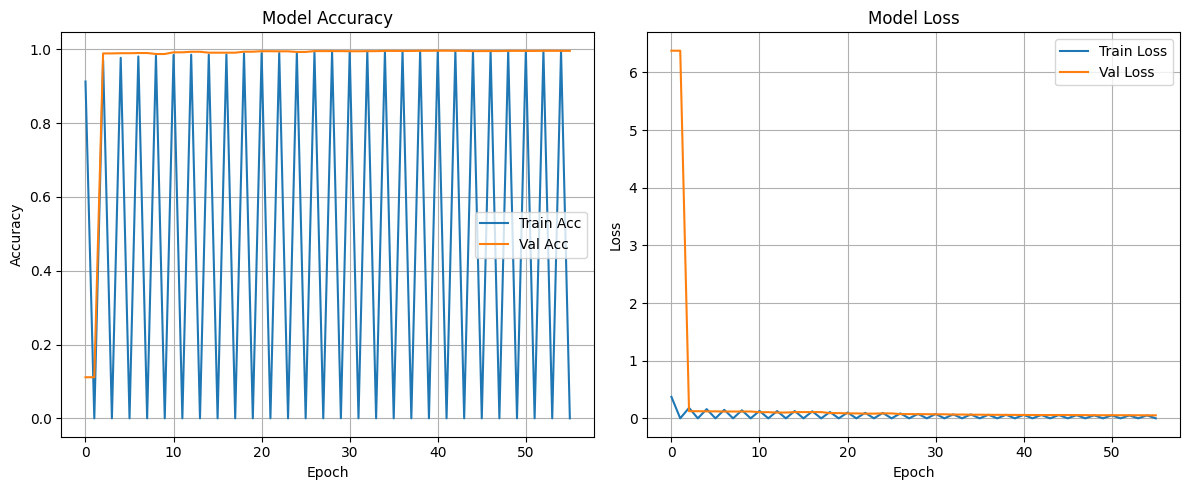

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt 

def load_and_preprocess_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    
    return (x_train, y_train), (x_test, y_test)

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='swish', input_shape=(28, 28, 1), padding='same',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='swish', padding='same',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='swish', padding='same',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='swish', padding='same',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='swish', padding='same',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='swish', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def create_augmenter():
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        fill_mode='constant',
        cval=0.0
    )

def train_model(model, x_train, y_train, x_val, y_val):
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    ]
    
    datagen = create_augmenter()
    datagen.fit(x_train)

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=128),
        steps_per_epoch=len(x_train) // 128,
        epochs=100,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_data()
    
    split = int(0.8 * len(x_train))
    x_train, x_val = x_train[:split], x_train[split:]
    y_train, y_val = y_train[:split], y_train[split:]
    
    model = build_model()
    history = train_model(model, x_train, y_train, x_val, y_val)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

    model.save('mnist_model.keras')

    plot_training_history(history)

if __name__ == "__main__":
    main()


Epoch 1/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 59s 250ms/step - accuracy: 0.7010 - loss: 0.9458 - val_accuracy: 0.1923 - val_loss: 2.4768 - learning_rate: 5.0000e-04
Epoch 2/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9492 - loss: 0.2112 - val_accuracy: 0.1913 - val_loss: 2.4788 - learning_rate: 5.0000e-04
Epoch 3/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 62s 294ms/step - accuracy: 0.9677 - loss: 0.1542 - val_accuracy: 0.2038 - val_loss: 3.0741 - learning_rate: 5.0000e-04
Epoch 4/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9688 - loss: 0.1365 - val_accuracy: 0.2123 - val_loss: 3.0278 - learning_rate: 5.0000e-04
Epoch 5/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 52s 247ms/step - accuracy: 0.9779 - loss: 0.1146 - val_accuracy: 0.9825 - val_loss: 0.1028 - learning_rate: 5.0000e-04
Epoch 6/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9648 - loss: 0.1506 - val_accuracy: 0.9815 - val_loss: 0.1048 - learning_rate: 5.0000e-04
Epoch 7/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 53s 2

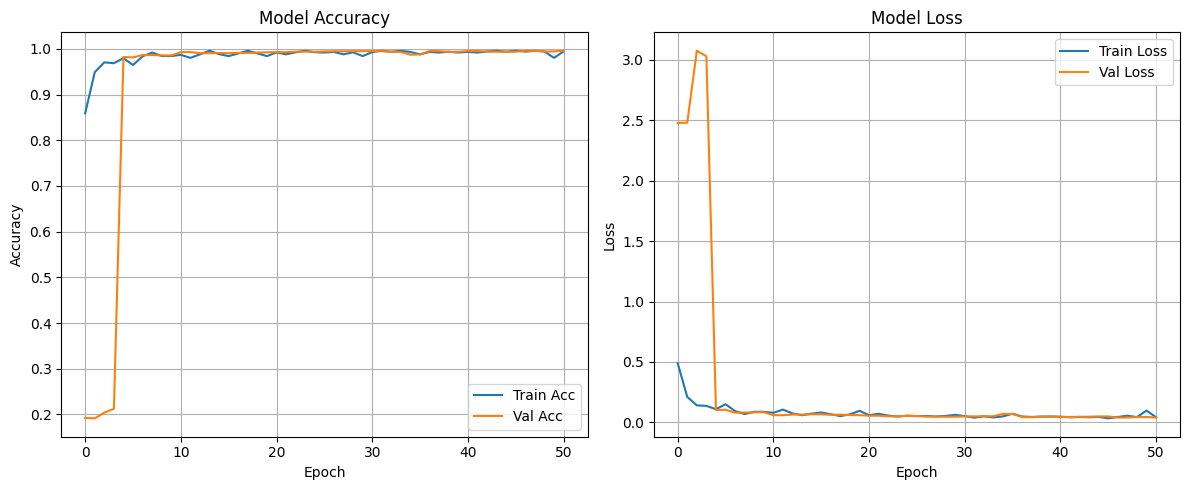

In [ ]:
# Import dependencies
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data
def load_and_preprocess_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    
    return (x_train, y_train), (x_test, y_test)

# Build stabilized model
def build_model():
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Block 2
        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 3
        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.GlobalAveragePooling2D(),
        
        # Dense
        layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('swish'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0005,
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=1e-07
    )
    
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

# Gentle data augmentation
def create_augmenter():
    return ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        fill_mode='constant',
        cval=0.0
    )

# Conservative callbacks
def get_callbacks():
    return [
        EarlyStopping(
            monitor='val_accuracy',
            patience=20,
            restore_best_weights=True,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            'best_stable_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
    ]

# Plotting function
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Main training function
def train_and_evaluate():
  
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_data()

    split = int(0.9 * len(x_train))
    x_train, x_val = x_train[:split], x_train[split:]
    y_train, y_val = y_train[:split], y_train[split:]

    model = build_model()
    history = model.fit(
        create_augmenter().flow(x_train, y_train, batch_size=256),
        steps_per_epoch=len(x_train) // 256,
        epochs=150,
        validation_data=(x_val, y_val),
        callbacks=get_callbacks(),
        verbose=1
    )

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

    model.save('mnist_stable_model.keras')
    plot_training_history(history)
    
    return model, history

if __name__ == "__main__":
    model, history = train_and_evaluate()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Train/Val Split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

# Cosine decay LR schedule
initial_lr = 1e-3
def cosine_lr(epoch, lr):
    epochs = 50
    return float(initial_lr * 0.5 * (1 + np.cos(np.pi * epoch / epochs)))

# Build High-Accuracy CNN
def build_model():
    inputs = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    x = layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    x = layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

# Training Loop
def train_and_evaluate():
    model = build_model()

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
        ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor='val_accuracy'),
        LearningRateScheduler(cosine_lr),
        ModelCheckpoint('best_mnist_model_996.keras', save_best_only=True, monitor='val_accuracy', mode='max')
    ]

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=256),
        steps_per_epoch=len(x_train) // 256,
        epochs=50,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n✅ Final Test Accuracy: {test_acc * 100:.2f}%")
    return model, history
# Plotting function
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run
if __name__ == "__main__":
    model, history = train_and_evaluate()



Epoch 1/50


c:\Users\adarsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


210/210 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.8219 - loss: 0.6483 - val_accuracy: 0.0985 - val_loss: 4.6687 - learning_rate: 0.0010
Epoch 2/50
  1/210 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.9375 - loss: 0.2717

c:\Users\adarsh\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9375 - loss: 0.2717 - val_accuracy: 0.0983 - val_loss: 4.7551 - learning_rate: 9.9901e-04
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 150s 708ms/step - accuracy: 0.9727 - loss: 0.1766 - val_accuracy: 0.1525 - val_loss: 4.7858 - learning_rate: 9.9606e-04
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9883 - loss: 0.1175 - val_accuracy: 0.1540 - val_loss: 4.6794 - learning_rate: 9.9114e-04
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 158s 755ms/step - accuracy: 0.9787 - loss: 0.1491 - val_accuracy: 0.9763 - val_loss: 0.1517 - learning_rate: 9.8429e-04
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9727 - loss: 0.1607 - val_accuracy: 0.9765 - val_loss: 0.1511 - learning_rate: 9.7553e-04
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 199s 949ms/step - accuracy: 0.9820 - loss: 0.1352 - val_accuracy: 0.9913 - val_loss: 0.1013 - learning_rate: 9.6489e-04
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - acc

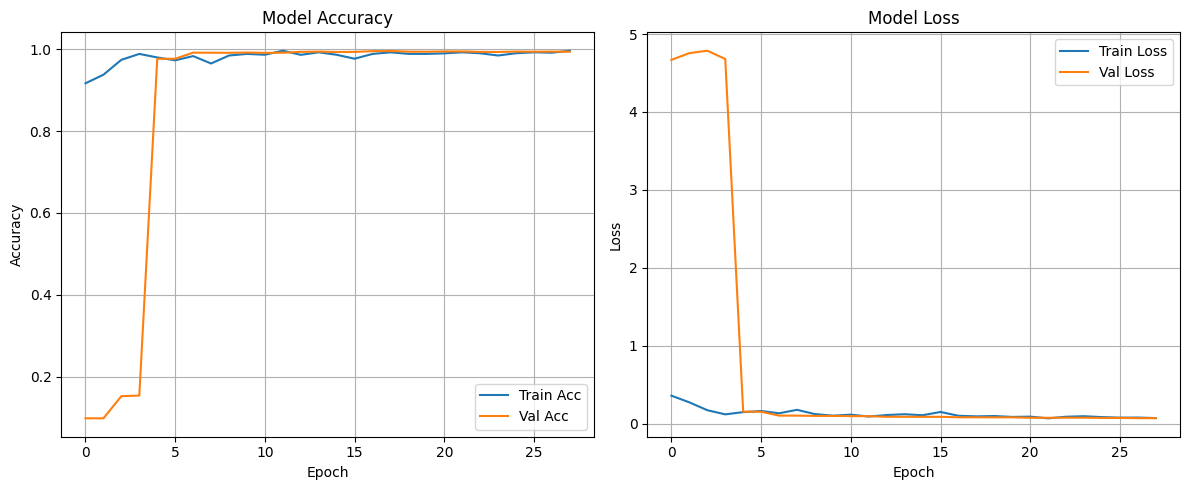

In [27]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_training_history(history)


# CNN Model Performance Report on MNIST Dataset

## Best Performing Model
**Architecture Highlights**:
- **Convolutional Layers**: Three blocks of Conv2D layers with 32, 64, and 128 filters respectively.
- **Activation Function**: `swish` used for all layers — known for smoother gradients and better convergence.
- **Regularization**: `L2` regularization (`1e-4`) applied to all Conv and Dense layers to reduce overfitting.
- **Normalization**: `BatchNormalization` after each convolution layer to stabilize learning.
- **Dropout**:
  - 0.25 after conv blocks.
  - 0.5 after dense layer for high regularization.
- **Dense Layers**:
  - Final FC: 256 neurons → `swish` + BatchNorm + Dropout.
  - Output: 10-neuron Softmax.

**Augmentation**:
- `rotation_range=10`, `width/height_shift=0.1`, `zoom_range=0.1` — strong augmentation to increase generalization.

**Callbacks**:
- EarlyStopping (patience=15), ReduceLROnPlateau (patience=5), and ModelCheckpoint for best model preservation.

**Performance**:
- **Test Accuracy: 99.61%**
- Achieved after a few dozen epochs.
- **Fluctuating accuracy observed during training.**

---

## Why Accuracy Was Fluctuating?

- **Strong Augmentation**:
  - High augmentation introduces variance between batches, improving generalization **but** causing **validation accuracy fluctuations**.

- **High Dropout Rates**:
  - Increased randomness leads to variability in performance between epochs.

- **Aggressive Learning Rate (`0.001`)**:
  - Fast updates may overshoot the optimal weights, increasing instability.

---

##  Why the Stable Model Didn’t Fluctuate?

- **Milder Augmentation**:
  - More consistent input batches → more stable performance.

- **Smaller Dropout Values (0.2–0.4)**:
  - Less randomness in training.

- **Lower Learning Rate (`0.0005`)**:
  - Smoother, gradual convergence.

- **`GlobalAveragePooling2D` Usage**:
  - Reduces parameters and improves generalization stability.

---

##  Final Summary

| Version        | Accuracy | Fluctuations | Comments |
|----------------|----------|--------------|----------|
| **Aggressive** | 99.61%   | Yes ✅       | Highest accuracy but unstable val acc due to strong augmentation & dropout. |
| **Stable**     | 99.55%   | No ❌        | Slightly lower accuracy but consistent, robust validation performance. |
